In [5]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/Projects/LSTM/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import numpy as np
import string, re
from string import digits
from numpy import array, argmax, random, take
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Read Data

In [7]:
def read_data(file_name="fra.txt"):
    data_path = f"{file_name}"
    df = pd.read_table(data_path, names=['source', 'target', 'comments'])
    df = df.drop(['comments'], axis = 1) 
    return df

In [8]:
df = read_data()
print(df.shape)
df.head()

(178009, 2)


,source,target
0,Go.,Va !
1,Hi.,Salut !
2,Hi.,Salut.
3,Run!,Cours !
4,Run!,Courez !


In [9]:
examples = 75000
df = df[:examples]
print(df.shape)
df.head()

(75000, 2)


,source,target
0,Go.,Va !
1,Hi.,Salut !
2,Hi.,Salut.
3,Run!,Cours !
4,Run!,Courez !


# Preprocess

In [10]:
def preprocess(df):
    # convert source and target text to Lowercase
    df.source = df.source.apply(lambda x: x.lower())
    df.target = df.target.apply(lambda x: x.lower())
    
    # creating a space between a word and the punctuation following it
    df.source = df.source.apply(lambda x: re.sub(r"([?.!,¿])", r" \1 ", x))
    df.target = df.target.apply(lambda x: re.sub(r"([?.!,¿])", r" \1 ", x))
    
    df.source = df.source.apply(lambda x: re.sub(r'[" "]+', " ", x))
    df.target = df.target.apply(lambda x: re.sub(r'[" "]+', " ", x))
    
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    df.source = df.source.apply(lambda x: re.sub(r"[^a-zA-Z?.!,¿]+", " ", x))
    df.target = df.target.apply(lambda x: re.sub(r"[^a-zA-Z?.!,¿]+", " ", x))
    
    # Remove digits from source and target sentences
    num_digits = str.maketrans('', '', digits)
    df.source = df.source.apply(lambda x: x.translate(num_digits))
    df.target = df.target.apply(lambda x: x.translate(num_digits))
    
    # Remove extra spaces
    df.source = df.source.apply(lambda x: x.strip())
    df.target = df.target.apply(lambda x: x.strip())
    df.source = df.source.apply(lambda x: re.sub(" +", " ", x))
    df.target = df.target.apply(lambda x: re.sub(" +", " ", x))

    # Add start and end tokens to target sequences
    df.target = df.target.apply(lambda x: 'START_ ' + x + ' _END')
    
    return df

In [11]:
df = preprocess(df)
df.head()

,source,target
0,go .,START_ va ! _END
1,hi .,START_ salut ! _END
2,hi .,START_ salut . _END
3,run !,START_ cours ! _END
4,run !,START_ courez ! _END


# Tokenization

In [12]:
def tokenization(data, maxlen = 100):
    token = Tokenizer(lower=True, oov_token='oov')
    token.fit_on_texts(data)
    
    data_seq = token.texts_to_sequences(data)
    data_pad = pad_sequences(data_seq, maxlen=maxlen, padding='post')
    
    return token, data_pad

In [13]:
maxlen = 50
token_src, tensor_src = tokenization(df['source'], maxlen)
token_trg, tensor_trg = tokenization(df['target'], maxlen)

In [14]:
# prepare english tokenizer
eng_tokenizer =token_src
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = maxlen
print('Size of English Vocabulary : %d' % eng_vocab_size)

# prepare Hindi tokenizer
hin_tokenizer = token_trg
hin_vocab_size = len(hin_tokenizer.word_index) + 1
hin_length = maxlen
print('Size of Hindi Vocabulary : %d' % hin_vocab_size)

Size of English Vocabulary : 7292
Size of Hindi Vocabulary : 11300


# Glove and Embedding Matrix

In [15]:
# creating glove vectors
def get_glove_vector():
    glove_vectors = {}

    with open("glove/glove.6B.100d.txt", "r", encoding="UTF-8") as glove:
        for line in glove:
            values = line.split()
            word = values[0]
            vectors = np.asarray(values[1:])
            glove_vectors[word] = vectors
    return glove_vectors

glove_vectors = get_glove_vector()
total_words = len(glove_vectors.keys()) 
total_words

400000

In [16]:
emb_dim = 100

# create word vector matrix with glove vectors
def create_word_vector_matrix(token, glove_vectors, vocab_size, emb_dim):
    word_vector_matrix = np.zeros((vocab_size, emb_dim))
    
    count = 0
    for word, index in token.word_index.items():
        vector = glove_vectors.get(word)
        if vector is not None:
            word_vector_matrix[index] = vector
        else:
            count += 1
    print(f"Vector not found for {count} words")
    return word_vector_matrix

In [17]:
emb_matrix_src = create_word_vector_matrix(token_src, glove_vectors, eng_vocab_size, emb_dim)
emb_matrix_trg = create_word_vector_matrix(token_trg, glove_vectors, hin_vocab_size, emb_dim)

Vector not found for 13 words
Vector not found for 7048 words


# Model

In [23]:
model_name = "models/"+"LSTM.h5"

modelcheckpoint = ModelCheckpoint(model_name,
                                  monitor='val_loss',
                                  mode='auto',
                                  verbose=1,
                                  save_best_only=True)

lr_callback = ReduceLROnPlateau(min_lr=0.000001)

callback_list = [modelcheckpoint, lr_callback]


model = Sequential()
model.add(Embedding(eng_vocab_size, 100, input_length=eng_length, mask_zero=True, weights=[emb_matrix_src]))
model.add(LSTM(512))
model.add(RepeatVector(hin_length))
model.add(LSTM(512, return_sequences=True))
model.add(Dense(hin_vocab_size, activation='softmax'))
 
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy',  metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           729200    
_________________________________________________________________
bidirectional (Bidirectional (None, 1024)              2510848   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 50, 1024)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 1024)          6295552   
_________________________________________________________________
dense (Dense)                (None, 50, 11300)         11582500  
Total params: 21,118,100
Trainable params: 21,118,100
Non-trainable params: 0
_________________________________________________________________


In [24]:
print(tensor_src.shape, tensor_trg.shape)

(75000, 50) (75000, 50)


In [25]:
history = model.fit(tensor_src, tensor_trg, epochs=10, batch_size=32, validation_split=0.2, callbacks=callback_list, shuffle=True)

Epoch 1/10
1875/1875 [==============================] - ETA: 0s - loss: 0.5622 - accuracy: 0.9070
Epoch 00001: val_loss improved from inf to 0.65051, saving model to models/LSTM.h5
1875/1875 [==============================] - 209s 111ms/step - loss: 0.5622 - accuracy: 0.9070 - val_loss: 0.6505 - val_accuracy: 0.8881
Epoch 2/10
1875/1875 [==============================] - ETA: 0s - loss: 0.4275 - accuracy: 0.9221
Epoch 00002: val_loss improved from 0.65051 to 0.57655, saving model to models/LSTM.h5
1875/1875 [==============================] - 207s 110ms/step - loss: 0.4275 - accuracy: 0.9221 - val_loss: 0.5766 - val_accuracy: 0.8964
Epoch 3/10
1875/1875 [==============================] - ETA: 0s - loss: 0.3704 - accuracy: 0.9293
Epoch 00003: val_loss improved from 0.57655 to 0.54835, saving model to models/LSTM.h5
1875/1875 [==============================] - 207s 110ms/step - loss: 0.3704 - accuracy: 0.9293 - val_loss: 0.5484 - val_accuracy: 0.9005
Epoch 4/10
1875/1875 [================

# Inference

In [26]:
reverse_word_index_src = {v: k for k, v in token_src.word_index.items()}
reverse_word_index_trg = {v: k for k, v in token_trg.word_index.items()}

In [59]:
def simplify(perdicted_tensor):
  string = ''
  for i in perdicted_tensor:
    word = reverse_word_index_trg.get(i)
    if word is not None:
      string += word + ' '
    # print(i, string)
  string = string.split(" ")[1:-2]
  ans = ''
  for j in string:
    ans += j + " "
  return ans[:-1]

In [67]:
res = model.predict_classes(tensor_src[50:51])

In [68]:
res = simplify(list(res[0]))
res

'je suis parti'

In [69]:
df['source'][50:51]

50    i left .
Name: source, dtype: object

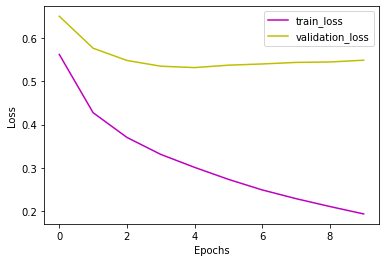

In [70]:
plt.plot(history.history['loss'], c='m')
plt.plot(history.history['val_loss'], c='y')
plt.legend(['train_loss', 'validation_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

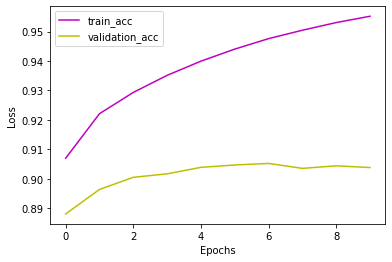

In [72]:
plt.plot(history.history['accuracy'], c='m')
plt.plot(history.history['val_accuracy'], c='y')
plt.legend(['train_acc', 'validation_acc'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()